In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error as mse, precision_score, recall_score
from sklearn import utils

from scikitplot.metrics import plot_confusion_matrix, plot_calibration_curve
from scikitplot.estimators import plot_learning_curve, plot_feature_importances

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from collections import defaultdict 

import gc
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [3]:
#loading the data
train = pd.read_hdf('train_online_retail.h5').reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520142 entries, 0 to 520141
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       520142 non-null  int32         
 1   stock_code    520142 non-null  int16         
 2   description   517903 non-null  object        
 3   quantity      520142 non-null  int32         
 4   invoice_date  520142 non-null  datetime64[ns]
 5   price_unit    520142 non-null  float16       
 6   price_total   520142 non-null  float32       
 7   customer_id   520142 non-null  int16         
 8   country       520142 non-null  object        
 9   is_canceled   520142 non-null  bool          
 10  is_test       520142 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 21.8+ MB


In [4]:
train.head(20)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
0,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,False
1,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,False
2,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,False
3,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,False
4,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,False
5,2,17,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-01 09:06:00,1.450195,17.400000,1,United Kingdom,False,False
6,2,18,HEART IVORY TRELLIS LARGE,12,2009-12-01 09:06:00,1.650391,19.799999,1,United Kingdom,False,False
7,2,19,HEART FILIGREE DOVE LARGE,12,2009-12-01 09:06:00,1.650391,19.799999,1,United Kingdom,False,False
8,2,20,FULL ENGLISH BREAKFAST PLATE,16,2009-12-01 09:06:00,3.390625,54.240002,1,United Kingdom,False,False
9,2,21,PIZZA PLATE IN BOX,4,2009-12-01 09:06:00,3.750000,15.000000,1,United Kingdom,False,False


## Dane:

- `invoice` - invoice number
- `stock_code` - product ID
- `description` - product description
- `quantity` - quantity of product bought in specific transaction
- `invoice_date` - date of invoice issue
- `price_unit` - unit price of product in pounds
- `price_total` - total price = `price_unit * quantity` 
- `customer_id` - customers ID
- `country` - name of the country from where the product was bought
- `is_canceled` - boolean value if product was retailed or not
- `is_test` - boolean value whether it's a test dataset

In [5]:
train['is_canceled'].value_counts()

False    510175
True       9967
Name: is_canceled, dtype: int64

In [6]:
test = pd.read_hdf('test_online_retail.h5').reset_index(drop=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547229 entries, 0 to 547228
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       547229 non-null  int32         
 1   stock_code    547229 non-null  int16         
 2   description   545086 non-null  object        
 3   quantity      547229 non-null  int32         
 4   invoice_date  547229 non-null  datetime64[ns]
 5   price_unit    547229 non-null  float16       
 6   price_total   547229 non-null  float32       
 7   customer_id   547229 non-null  int16         
 8   country       547229 non-null  object        
 9   is_test       547229 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 22.4+ MB


In [7]:
test.head()

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_test
0,0,0,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.949219,83.400002,0,United Kingdom,True
1,0,1,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,81.000000,0,United Kingdom,True
2,0,2,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,81.000000,0,United Kingdom,True
3,0,3,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.099609,100.800003,0,United Kingdom,True
4,0,4,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250000,30.000000,0,United Kingdom,True


In [8]:
def dist(df):
    print('detailed')
    print( df['is_canceled'].value_counts(normalize=True).values * 100)
    
    df_agg = df.groupby('invoice').sum()
    df_agg['is_canceled'] = (df_agg['is_canceled'] > 0).astype(np.int)

    print('orders')
    print(df_agg['is_canceled'].value_counts(normalize=True).values * 100)

dist(train)

detailed
[98.0837925  1.9162075]
orders
[84.53792795 15.46207205]


In [9]:
X = train[['invoice', 'is_canceled']].values
y = train['is_canceled'].values
groups = train['invoice'].values

X_shuffled, y_shuffled, groups_shuffled = utils.shuffle(X, y, groups)

group_kfold = GroupKFold(n_splits=10)

for train_idx, test_idx in group_kfold.split(X_shuffled, y_shuffled, groups_shuffled):    
    sel_df = train[ train.invoice.isin( groups_shuffled[test_idx]) ]
    dist(sel_df)
    print("=====\n\n")

detailed
[97.98327406  2.01672594]
orders
[83.92390899 16.07609101]
=====


detailed
[97.74103624  2.25896376]
orders
[84.37150317 15.62849683]
=====


detailed
[98.22932287  1.77067713]
orders
[84.70149254 15.29850746]
=====


detailed
[98.20240704  1.79759296]
orders
[84.25960463 15.74039537]
=====


detailed
[98.05244742  1.94755258]
orders
[84.48340172 15.51659828]
=====


detailed
[98.11396932  1.88603068]
orders
[84.34004474 15.65995526]
=====


detailed
[98.16587842  1.83412158]
orders
[85.30947054 14.69052946]
=====


detailed
[98.09282116  1.90717884]
orders
[84.97390007 15.02609993]
=====


detailed
[98.16395586  1.83604414]
orders
[84.37733035 15.62266965]
=====


detailed
[98.09282116  1.90717884]
orders
[84.6383296 15.3616704]
=====




In [10]:
#function to get features that we will use for model training
def get_feats(df):
    feats = df.select_dtypes(np.number, np.bool).columns
    black_list = ['is_canceled', 'is_test', 'is_canceled_pred', 'total_return', 'total_return_pred']
    
    feats = [feat for feat in feats if feat not in black_list]
    
    return feats

In [11]:
#class for cross validation with GroupKfold method

class CrossValidation:
    def __init__(self, groups, index, shuffle=True, n_splits=5, random_state=8888):
        self.n_splits = n_splits
        self.groups = groups
        self.index = index
        self.shuffle = shuffle
        self.random_state = random_state
    
    def kfold_split(self, X, y, groups=None):
        if self.shuffle:
            X, y, self.groups, self.index = utils.shuffle(X, y, self.groups, self.index, random_state = self.random_state)
        
        group_kfold = GroupKFold(n_splits = self.n_splits)
        
        for train_idx, test_idx in group_kfold.split(X, y, self.groups):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            
            yield train_idx, test_idx
    
    def get_index(self):
        return self.index

In [12]:
#function for calculating mse metric on aggregated data

def group_and_calc_mse(train):
    train_agg = train.groupby('invoice')[ ['price_total', 'is_canceled_pred', 'is_canceled'] ].sum()

    train_agg['is_canceled'] = train_agg['is_canceled'] > 0
    train_agg['is_canceled_pred'] = train_agg['is_canceled_pred'] > 0

    train_agg['total_return'] = train_agg['price_total'] * train_agg['is_canceled']
    train_agg['total_return_pred'] = train_agg['price_total'] * train_agg['is_canceled_pred']

    return mse( train_agg['total_return'].values,  train_agg['total_return_pred'].values)

In [13]:
#function to update test fold
def update_test_fold(y_pred, df, index_map, test_idx, pred_feat='is_canceled_pred'):
    sel_index = df.index.isin( index_map[test_idx] )
    df.loc[ sel_index, [pred_feat]] = y_pred

In [14]:
#function to run cross validation with plot learning curve, confusion_matrix and feature importance
def run_cv(train, model_cls, model_params, n_splits=5, shuffle_rows=True, target='is_canceled', 
            is_plot_learning_curve=True, is_plot_confusion_matrix=True, is_plot_feature_importances=True):
        
        train.fillna(-1, inplace=True)
        
        feats = get_feats(train)
        print(feats)
        
        X = train[feats].values
        y = train[target].values
        
        pred_feature = '{}_pred'.format(target)
        train[pred_feature] = np.nan
        
        cv = CrossValidation(train['invoice'], train.index)
        
        for train_idx, test_idx in cv.kfold_split(X, y):    
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test   = X[test_idx], y[test_idx]

            model = model_cls(**model_params)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            update_test_fold(y_pred, train, cv.get_index(), test_idx)        
        
        train[pred_feature] = train[pred_feature].astype('str')
        train[pred_feature] = train[pred_feature]=='True'
        
        print('mse: ', group_and_calc_mse(train))
        
        if is_plot_learning_curve:
            title = 'Learning curve: {} {}'.format(model_cls.__name__, model_params)
            cv = CrossValidation(train['invoice'], train.index)
            plot_learning_curve(model_cls(**model_params), X, y, title=title, figsize=(15, 5), random_state=0, cv=n_splits, scoring='recall')

        if is_plot_confusion_matrix:
            plot_confusion_matrix(train['is_canceled'], train[pred_feature])
    
        if is_plot_feature_importances:
            model = model_cls(**model_params)
            model.fit(X, y)
            perm = PermutationImportance(model, random_state=8888).fit(X, y)
            return eli5.show_weights(perm, feature_names=feats)

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  2171152.0


C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\eli5\formatters\html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,customer_id
0 ± 0.0000,price_total
0 ± 0.0000,price_unit
0 ± 0.0000,quantity
0 ± 0.0000,stock_code
0 ± 0.0000,invoice


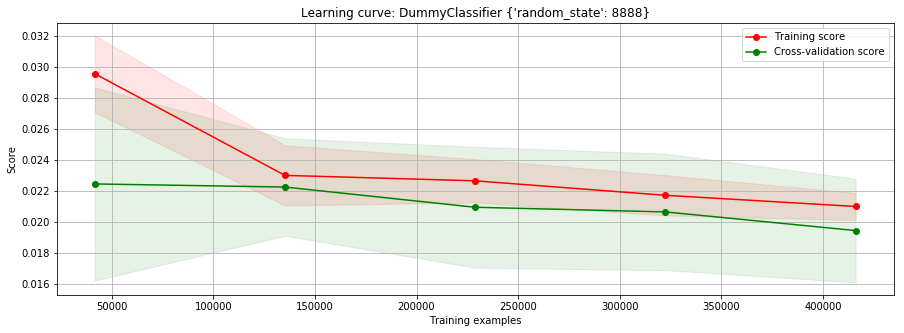

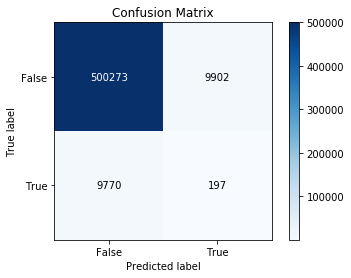

In [15]:
#checking dummy classifier
run_cv(train, DummyClassifier, {'random_state': 8888})

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  2347498.0


C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\eli5\formatters\html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,customer_id
0 ± 0.0000,price_total
0 ± 0.0000,price_unit
0 ± 0.0000,quantity
0 ± 0.0000,stock_code
0 ± 0.0000,invoice


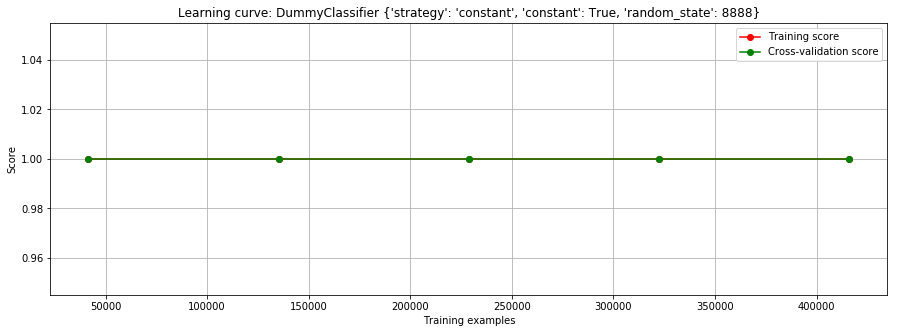

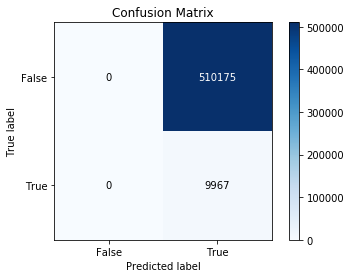

In [16]:
run_cv(train, DummyClassifier, {'strategy': 'constant', 'constant': True, 'random_state': 8888})

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  1493827.1


C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\eli5\formatters\html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,customer_id
0 ± 0.0000,price_total
0 ± 0.0000,price_unit
0 ± 0.0000,quantity
0 ± 0.0000,stock_code
0 ± 0.0000,invoice


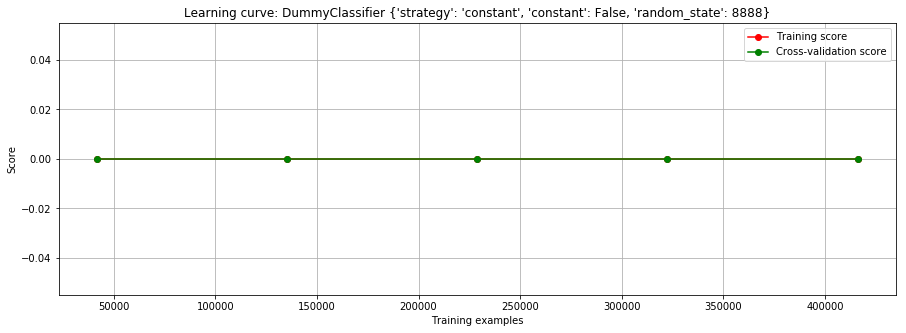

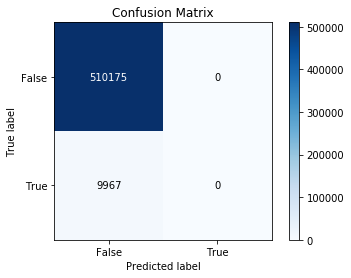

In [17]:
run_cv(train, DummyClassifier, {'strategy': 'constant', 'constant': False, 'random_state': 8888})

['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id']
mse:  1578067.8


Weight,Feature
0.0184 ± 0.0002,price_unit
0.0175 ± 0.0002,price_total
0.0028 ± 0.0001,customer_id
0.0021 ± 0.0000,stock_code
0.0020 ± 0.0001,quantity
0.0008 ± 0.0001,invoice


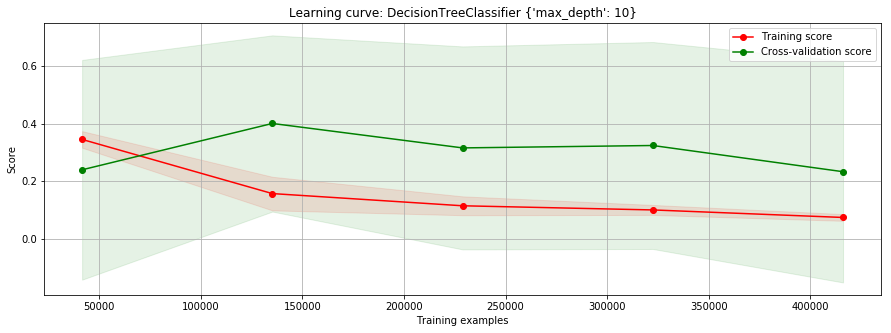

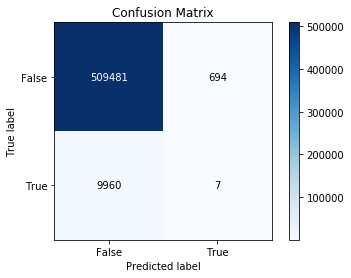

In [18]:
run_cv(train, DecisionTreeClassifier, {'max_depth': 10})

FEATURE ENGINEERING

In [19]:
#kaggle submission
#orders_test['total_return'] = y_pred
#orders_test[ ['invoice', 'total_return'] ].to_csv('submit_dummy_model.csv', index=False) 